In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import itertools
import pandas as pd
from IPython.display import display, HTML

In [2]:
def DeltaR(eta1,phi1, eta2,phi2):
    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

def FourMomentum(pt, eta, phi, m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return e, px, py, pz

def PtEtaPhiM(px, py, pz, e):
    E, px, py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(np.sqrt((E**2 - px**2 - py**2 - pz**2)**2))

    return pt, eta, phi, m
    
def InvM(e, px, py, pz):
    return np.sqrt(e**2 - px**2 - py**2 - pz**2)

def Mjets(*arg):
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

In [3]:
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest              

In [4]:
def display_cutflow_table(result):
    nevent = result['nevent']
    cut_list = ['Eta PT BTag cut', 'Delta R', 'Higgs PT cut', 'Higgs Eta cut', 'Higgs signal','Top veto']
    pass_rate_list = []
    efficiency_list = []
    
    for i, cut in enumerate(cut_list):
        pass_rate_list.append(result[cut]/nevent)
        if i == 0:
            efficiency_list.append(pass_rate_list[i]/1)
        else:
            efficiency_list.append(pass_rate_list[i]/pass_rate_list[i-1])
    data = {'Cut': cut_list, 'pass rate': pass_rate_list, 'efficiency': efficiency_list}
    
    df = pd.DataFrame(data)
    
    display(df)

## ATLAS diHiggs selection 

In [5]:
def deltaR_condition(R1, R2, m4j):
    # R1: Delta R of leading Higgs candidate
    # R2: Delta R of sub-leading Higgs candidate
    
    if m4j < 1250:
        if R1 > 653 / m4j + 0.475:
            return False
        if R1 < 360 / m4j - 0.5:
            return False

        if R2 > 875 / m4j + 0.35:
            return False
        if R2 < 235 / m4j:
            return False      
    else:
        if R1 > 1:
            return False
        if R1 < 0:
            return False

        if R2 > 1:
            return False
        if R2 < 0:
            return False
    return True

def DHH(m1, m2):
    # m1: leading Higgs candidate mass
    # m2: sub-leading Higgs candidate mass
    
    return abs(m1 - 120/110*m2) / (1 + (120/110)**2)**0.5
    
def pt_condition(pt1, pt2, m4j):
#     if pt1 < pt2:
#         pt1, pt2 = pt2, pt1
        
    if pt1 < 0.5 * m4j - 103:
        return False
    if pt2 < 0.33 * m4j - 73:
        return False
    return True

def XHH(m1, m2):
    # m1: leading Higgs candidate mass
    # m2: sub-leading Higgs candidate mass
    
    return (((m1-120)/(0.1*m1))**2 + ((m2-110)/(0.1*m2))**2)**0.5

def XWt(mW, mt):
    # mW: W boson candidate mass
    # mt: top candidate mass
    
    return (((mW-80)/(0.1*mW))**2 + ((mt-173)/(0.1*mt))**2)**0.5

In [6]:
def diHiggs_selection_ATLAS(file_path, mass, xection=None, title='', nevent_max=1000):
    # Eta PT BTag cut: |eta| < 2.5, PT > 40 GeV for 4 b-jets
    
    root_file = uproot.open(file_path)['Delphes;1']

    Eta_PT_BTag_count = 0
    dR_count = 0
    HPT_count = 0
    HEta_count = 0
    XHH_count = 0
    XWt_count = 0

    jet_PT = root_file['Jet.PT'].array(entry_stop=nevent_max)
    jet_Eta = root_file['Jet.Eta'].array(entry_stop=nevent_max)
    jet_Phi = root_file['Jet.Phi'].array(entry_stop=nevent_max)
    jet_Mass = root_file['Jet.Mass'].array(entry_stop=nevent_max)
    jet_BTag = root_file['Jet.BTag'].array(entry_stop=nevent_max)
    
    if xection:
        cross_section = xection
    else:
        # unit: pb -> fb
        cross_section = root_file['Event.Weight'].array(entry_stop=1)[0][0] * 1000
    
    nevent = min(len(jet_PT), nevent_max)
    
    for event in tqdm(range(nevent)):
        
        # |eta| < 2.5 & PT > 40 GeV
        eta_pt_cut = np.where((np.abs(jet_Eta[event]) < 2.5) & (jet_PT[event] > 40))[0]
        
        # |eta| < 2.5 & PT > 40 GeV & b-tagged
        eta_pt_bTag_cut = np.where((np.abs(jet_Eta[event]) < 2.5) & (jet_PT[event] > 40) & (jet_BTag[event] == 1))[0]

        # >= 4 b-jet
        if len(eta_pt_bTag_cut) < 4: 
            continue
        Eta_PT_BTag_count += 1
        
        # choose 4 highest pt b-jets
        h_jets = eta_pt_bTag_cut[0:4]

        PT = jet_PT[event][h_jets]
        Eta = jet_Eta[event][h_jets]
        Phi = jet_Phi[event][h_jets]
        Mass = jet_Mass[event][h_jets]

        e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
        m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

        # The pairing satisfy the delta R condition
        dR_pairing = []
        for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):
            PT1 = PT[[i1,i2]]
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]
            
            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            mH1 = InvM(np.sum(e1), np.sum(px1), np.sum(py1), np.sum(pz1))
            
            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]
            
            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            mH2 = InvM(np.sum(e2), np.sum(px2), np.sum(py2), np.sum(pz2))
            
            # sorted by PT scalar sum
            if np.sum(PT1) < np.sum(PT2):
                PT1, PT2 = PT2, PT1
                Eta1, Eta2 = Eta2, Eta1
                Phi1, Phi2 = Phi2, Phi1
                Mass1, Mass2 = Mass2, Mass1
                i1, i2, i3, i4 = i3, i4, i1, i2
                
            dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
            dR2 = DeltaR(Eta2[0], Phi2[0], Eta2[1], Phi2[1])
            
            if deltaR_condition(dR1, dR2, m4j):
                d = DHH(mH1, mH2)
                dR_pairing.append([i1,i2,i3,i4, d])
                
        if len(dR_pairing) == 0:
            continue
        dR_count += 1
        
        # choose the pairing with minimum DHH
        min_DHH = -1
        h_candidate = []
        for i1,i2,i3,i4, d in dR_pairing:
            if min_DHH < 0 or d < min_DHH:
                min_DHH = d
                h_candidate = [i1,i2,i3,i4]
                
        i1, i2 = h_candidate[0:2] 
        i3, i4 = h_candidate[2:4] 
        
        PT1 = PT[[i1,i2]]
        Eta1 = Eta[[i1,i2]]
        Phi1 = Phi[[i1,i2]]
        Mass1 = Mass[[i1,i2]]

        e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
        PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

        PT2 = PT[[i3,i4]]
        Eta2 = Eta[[i3,i4]]
        Phi2 = Phi[[i3,i4]]
        Mass2 = Mass[[i3,i4]]

        e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
        PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))
           
#         # sorted by PT vector sum
#         if PTH1 < PTH2:
#             PTH1, EtaH1, PhiH1, MassH1, PTH2, EtaH2, PhiH2, MassH2 = PTH2, EtaH2, PhiH2, MassH2, PTH1, EtaH1, PhiH1, MassH1
            
        if not pt_condition(PTH1, PTH2, m4j):
            continue
        HPT_count += 1    
        
        if abs(EtaH1 - EtaH2) > 1.5:
            continue
        HEta_count += 1
        
        # signal region
        if XHH(MassH1, MassH2) > 1.6:
            continue
        XHH_count += 1
        
        # Top veto
        not_h_jets = []
        for jet in eta_pt_cut:
            if jet not in h_jets:
                not_h_jets.append(jet)
        
        XWt_flag = True
        if len(not_h_jets) >= 2:
            for i1,i2 in itertools.combinations(not_h_jets, 2):
                PTW = jet_PT[event][[i1,i2]]
                EtaW = jet_Eta[event][[i1,i2]]
                PhiW = jet_Phi[event][[i1,i2]]
                MassW = jet_Mass[event][[i1,i2]]

                eW, pxW, pyW, pzW = FourMomentum(PTW, EtaW, PhiW, MassW)
                mW = InvM(np.sum(eW), np.sum(pxW), np.sum(pyW), np.sum(pzW))

                for b in h_jets:
                    PTb = jet_PT[event][b]
                    Etab = jet_Eta[event][b]
                    Phib = jet_Phi[event][b]
                    Massb = jet_Mass[event][b]
                    eb, pxb, pyb, pzb = FourMomentum(PTb, Etab, Phib, Massb)

                    et, pxt, pyt, pzt = np.sum(eW) + eb, np.sum(pxW) + pxb, np.sum(pyW) + pyb, np.sum(pzW) + pzb
                    mt = InvM(et, pxt, pyt, pzt)

                    if XWt(mW, mt) < 1.5:
                        XWt_flag = False
                        break
        if XWt_flag:                
            XWt_count += 1

    print(title)
    print(f'In {nevent} events')
    print(f'Cross section: {cross_section} fb')

    print('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', Eta_PT_BTag_count, cross_section * Eta_PT_BTag_count / nevent)
    print('Delta R:', dR_count, dR_count * cross_section / nevent)
    print('Higgs PT:', HPT_count, HPT_count * cross_section / nevent)
    print('Higgs Eta:', HEta_count, HEta_count * cross_section / nevent)
    print('Higgs signal region:', XHH_count, XHH_count * cross_section / nevent)
    print('Top veto:', XWt_count, XWt_count * cross_section / nevent)

    
    result = {
        'Mass': mass,
        'nevent': nevent,
        'Cross section': cross_section,
        'Eta PT BTag cut': Eta_PT_BTag_count,
        'Delta R': dR_count,
        'Higgs PT cut': HPT_count,
        'Higgs Eta cut': HEta_count,
        'Higgs signal': XHH_count,
        'Top veto': XWt_count, 
    }
    return result

In [7]:
def get_number_of_bjet(file_path, mass, xection=None, title='', nevent_max=1000):
    # Eta PT BTag cut: |eta| < 2.5, PT > 40 GeV for 4 b-jets
    
    root_file = uproot.open(file_path)['Delphes;1']

    Eta_PT_BTag_count = 0

    jet_PT = root_file['Jet.PT'].array(entry_stop=nevent_max)
    jet_Eta = root_file['Jet.Eta'].array(entry_stop=nevent_max)
#     jet_Phi = root_file['Jet.Phi'].array(entry_stop=nevent_max)
#     jet_Mass = root_file['Jet.Mass'].array(entry_stop=nevent_max)
    jet_BTag = root_file['Jet.BTag'].array(entry_stop=nevent_max)
    
    if xection:
        cross_section = xection
    else:
        # unit: pb -> fb
        cross_section = root_file['Event.Weight'].array(entry_stop=1)[0][0] * 1000
    
    nevent = min(len(jet_PT), nevent_max)
    
    # 0: before Four tag cut, 1: after Four tag cut
    nbj = [[], []]
    
    for event in tqdm(range(nevent)):
        
        BTag = jet_BTag[event]

        nbj[0].append(np.sum(BTag))
        
        # |eta| < 2.5 & PT > 40 GeV
        eta_pt_cut = np.where((np.abs(jet_Eta[event]) < 2.5) & (jet_PT[event] > 40))[0]
        
        # |eta| < 2.5 & PT > 40 GeV & b-tagged
        eta_pt_bTag_cut = np.where((np.abs(jet_Eta[event]) < 2.5) & (jet_PT[event] > 40) & (jet_BTag[event] == 1))[0]

        # >= 4 b-jet
        if len(eta_pt_bTag_cut) < 4: 
            continue
        Eta_PT_BTag_count += 1
        
        nbj[1].append(len(eta_pt_bTag_cut))
        

    print(title)
    print(f'In {nevent} events')
    print(f'Cross section: {cross_section} fb')

    print('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', Eta_PT_BTag_count, cross_section * Eta_PT_BTag_count / nevent)
#     print('Delta R:', dR_count, dR_count * cross_section / nevent)
#     print('Higgs PT:', HPT_count, HPT_count * cross_section / nevent)
#     print('Higgs Eta:', HEta_count, HEta_count * cross_section / nevent)
#     print('Higgs signal region:', XHH_count, XHH_count * cross_section / nevent)
#     print('Top veto:', XWt_count, XWt_count * cross_section / nevent)

    
#     result = {
#         'Mass': mass,
#         'nevent': nevent,
#         'Cross section': cross_section,
#         'Eta PT BTag cut': Eta_PT_BTag_count,
#         'Delta R': dR_count,
#         'Higgs PT cut': HPT_count,
#         'Higgs Eta cut': HEta_count,
#         'Higgs signal': XHH_count,
#         'Top veto': XWt_count, 
#     }
    return nbj

### HDF5

In [8]:
def diHiggs_selection_ATLAS_HDF5_deltaR(file_path, mass, xection=None, title='', nevent_max=1000):
    # input file has jet matching data
    # count how many events in which the four b-jets all from Higgs
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        dR_count1 = 0
        dR_count2 = 0
        dR_count3 = 0

        cross_section = xection

        # 0: all from Higgs, 1: not all from Higgs
        dR_list = [[[],[]], [[],[]]]
        m4j_list = [[], []]

        correct_pair_count = 0
        incorrect_pair_count1 = 0
        incorrect_pair_count2 = 0
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        for event in tqdm(range(nevent)):

            nj = f['source/mask'][event].sum()
            jet_PT = f['source/pt'][event][:nj]
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = f['source/mass'][event][:nj]
            jet_BTag = f['source/btag'][event][:nj]
            
            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1
            
            # choose 4 highest pt b-jets
            h_jets = eta_pt_bTag_cut[0:4]

            if not(f['h1/mask'][event] and f['h2/mask'][event]):
                continue
                
            # correct jet matching
            h_id = [f['h1/b1'][event], f['h1/b2'][event], 
                    f['h2/b1'][event], f['h2/b2'][event],]

            # compare to the correct jet matching
            correct = True
            for j in h_id:
                if j not in h_jets:
                    correct = False
                    break
            all_jet_in_eta_pt_bTag_cut = True
            for j in h_id:
                if j not in eta_pt_bTag_cut:
                    all_jet_in_eta_pt_bTag_cut = False
                    break

            if correct:
                correct_pair_count += 1
            else:
                if all_jet_in_eta_pt_bTag_cut:
                    incorrect_pair_count1 += 1
                else:
                    incorrect_pair_count2 += 1
                    
            # Total invariant mass of 4 b-jets
            PT = jet_PT[h_jets]
            Eta = jet_Eta[h_jets]
            Phi = jet_Phi[h_jets]
            Mass = jet_Mass[h_jets]
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

            # The pairing satisfy the delta R condition
            dR_pairing = []
            for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):
                PT1 = PT[[i1,i2]]
                Eta1 = Eta[[i1,i2]]
                Phi1 = Phi[[i1,i2]]
                Mass1 = Mass[[i1,i2]]
                e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
                mH1 = InvM(np.sum(e1), np.sum(px1), np.sum(py1), np.sum(pz1))

                PT2 = PT[[i3,i4]]
                Eta2 = Eta[[i3,i4]]
                Phi2 = Phi[[i3,i4]]
                Mass2 = Mass[[i3,i4]]
                e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
                mH2 = InvM(np.sum(e2), np.sum(px2), np.sum(py2), np.sum(pz2))

                if np.sum(PT1) < np.sum(PT2):
                    PT1, PT2 = PT2, PT1
                    Eta1, Eta2 = Eta2, Eta1
                    Phi1, Phi2 = Phi2, Phi1
                    Mass1, Mass2 = Mass2, Mass1
                    i1, i2, i3, i4 = i3, i4, i1, i2

                dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
                dR2 = DeltaR(Eta2[0], Phi2[0], Eta2[1], Phi2[1])

                if deltaR_condition(dR1, dR2, m4j):
                    d = DHH(mH1, mH2)
                    dR_pairing.append([i1,i2,i3,i4, d, dR1, dR2])
            
            if len(dR_pairing) > 0 :
                if correct:
                    dR_count1 += 1
                else:
                    if all_jet_in_eta_pt_bTag_cut:
                        dR_count2 += 1
                    else:
                        dR_count3 += 1

            if len(dR_pairing) == 0:
                continue
            dR_count += 1

            min_DHH = -1
            h_candidate = []
            deltaR = []
            for i1,i2,i3,i4, d, dR1, dR2 in dR_pairing:
                if min_DHH < 0 or d < min_DHH:
                    min_DHH = d
                    h_candidate = [i1,i2,i3,i4]
                    deltaR = [dR1, dR2]

            if correct: 
                dR_list[0][0].append(deltaR[0])
                dR_list[0][1].append(deltaR[1])
                m4j_list[0].append(m4j)
            else:
                dR_list[1][0].append(deltaR[0])
                dR_list[1][1].append(deltaR[1])
                m4j_list[1].append(m4j)

        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

        print('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', Eta_PT_BTag_count, cross_section * Eta_PT_BTag_count / nevent)
        print(f'Total: {correct_pair_count + incorrect_pair_count1 + incorrect_pair_count2}, All from Higgs: {correct_pair_count}, not all from Higgs: {incorrect_pair_count1 + incorrect_pair_count2}')
        print('Delta R:', dR_count, dR_count * cross_section / nevent)
        print(f'Total: {dR_count1 + dR_count2 + dR_count3}, All from Higgs: {dR_count1}, not all from Higgs: {dR_count2 + dR_count3}')

        result = {
            'Mass': mass,
            'nevent': nevent,
            'Cross section': cross_section,
            'Eta PT BTag cut': Eta_PT_BTag_count,
            'Delta R': dR_count,
        }
        return result, dR_list, m4j_list

### Signal

In [9]:
# 13 TeV 100k pp->H->hh b-tagging efficiency=default H = 1000 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_55_decayed_1/tag_1_delphes_events.root'

result_1000_s = diHiggs_selection_ATLAS(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:19<00:00, 125.03it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 13864 0.1159695872
Delta R: 10891 0.09110103680000001
Higgs PT: 8708 0.0728406784
Higgs Eta: 8033 0.0671944384
Higgs signal region: 4218 0.0352827264
Top veto: 4181 0.0349732288


In [10]:
display_cutflow_table(result_1000_s)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.13864,0.138640
1,Delta R,0.10891,0.785560
2,Higgs PT cut,0.08708,0.799559
3,Higgs Eta cut,0.08033,0.922485
4,Higgs signal,0.04218,0.525084
5,Top veto,0.04181,0.991228


In [11]:
# 13 TeV 100k pp->H->hh b-tagging efficiency=default H = 600 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_58_decayed_1/tag_1_delphes_events.root'

result_600_s = diHiggs_selection_ATLAS(file_path, mass = 600, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [12:02<00:00, 138.37it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 11199 0.09367739519999999
Delta R: 8562 0.0716194176
Higgs PT: 8195 0.068549536
Higgs Eta: 7334 0.0613474432
Higgs signal region: 2897 0.0242328256
Top veto: 2868 0.0239902464


In [12]:
display_cutflow_table(result_600_s)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.11199,0.111990
1,Delta R,0.08562,0.764533
2,Higgs PT cut,0.08195,0.957136
3,Higgs Eta cut,0.07334,0.894936
4,Higgs signal,0.02897,0.395010
5,Top veto,0.02868,0.989990


In [13]:
# 13 TeV 100k pp->H->hh b-tagging efficiency=default*0.92 H = 1000 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_65_decayed_1/tag_1_delphes_events.root'

result_1000_btag_s = diHiggs_selection_ATLAS(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [11:54<00:00, 139.98it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 10061 0.08415825279999999
Delta R: 7805 0.065287264
Higgs PT: 6264 0.0523971072
Higgs Eta: 5745 0.048055775999999994
Higgs signal region: 2977 0.0249020096
Top veto: 2949 0.024667795200000002


In [14]:
display_cutflow_table(result_1000_btag_s)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.10061,0.100610
1,Delta R,0.07805,0.775768
2,Higgs PT cut,0.06264,0.802562
3,Higgs Eta cut,0.05745,0.917146
4,Higgs signal,0.02977,0.518190
5,Top veto,0.02949,0.990595


In [15]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'

result_1000_MV2c10_s = diHiggs_selection_ATLAS(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:34<00:00, 122.85it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12574 0.10517899520000001
Delta R: 10868 0.0909086464
Higgs PT: 8963 0.07497370240000001
Higgs Eta: 8260 0.06909324800000001
Higgs signal region: 4453 0.0372484544
Top veto: 4408 0.0368720384


In [16]:
display_cutflow_table(result_1000_MV2c10_s)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.12574,0.125740
1,Delta R,0.10868,0.864323
2,Higgs PT cut,0.08963,0.824715
3,Higgs Eta cut,0.08260,0.921566
4,Higgs signal,0.04453,0.539104
5,Top veto,0.04408,0.989894


#### HDF5

In [17]:
# 13 TeV 100k pp->H->hh b-tagging efficiency=default H = 1000 GeV
file_path = '100k_diHiggs_0b_default.h5'

signal_info_HDF5, dR_HDF5, m4j_HDF5 = diHiggs_selection_ATLAS_HDF5_deltaR(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:03<00:00, 544.11it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 13863 0.11596122240000001
Total: 11884, All from Higgs: 9348, not all from Higgs: 2536
Delta R: 9818 0.0821256064
Total: 9818, All from Higgs: 8961, not all from Higgs: 857


In [18]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '100k_diHiggs_0b_ATLAS.h5'

signal_info_HDF5, dR1_HDF5, m4j_HDF5 = diHiggs_selection_ATLAS_HDF5_deltaR(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:57<00:00, 564.22it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 10060 0.08414988799999999
Total: 8600, All from Higgs: 6604, not all from Higgs: 1996
Delta R: 7015 0.058679072
Total: 7015, All from Higgs: 6343, not all from Higgs: 672


### Number of b-jets

In [19]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'

nbj = get_number_of_bjet(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:58<00:00, 334.55it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12574 0.10517899520000001


Before Four Tag cut
total events: 100000
> 4 b-jets: 1063
After Four Tag cut
total events: 12574
> 4 b-jets: 480


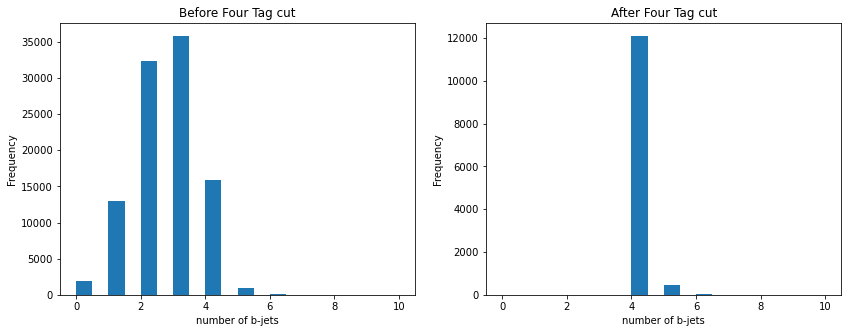

In [20]:
data1 = np.array(nbj[0])
data2 = np.array(nbj[1])

print('Before Four Tag cut')
print("total events:", len(data1))
print("> 4 b-jets:", (data1 > 4).sum())
print('After Four Tag cut')
print("total events:", len(data2))
print("> 4 b-jets:", (data2 > 4).sum())

# title = "pp->4b"

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].hist(data1, bins = 20, range=(0, 10))
ax[0].set_xlabel('number of b-jets')
ax[0].set_ylabel("Frequency")
ax[0].set_title('Before Four Tag cut')

ax[1].hist(data2, bins = 20, range=(0, 10))
ax[1].set_xlabel('number of b-jets')
ax[1].set_ylabel("Frequency")
ax[1].set_title('After Four Tag cut')

# plt.savefig("number_of_b-jets.png", facecolor="White")
plt.show()